<a href="https://colab.research.google.com/github/joaochenriques/GeneratorCalib/blob/main/GenFilterPaper_PP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
CASES = {
    0: ( 'T00', '17VPMsByFk7y7hvfCulCVsXU9NFCYm80m' ),
    1: ( 'T01', '1ntRq9wLbatJs7RiALXIoL55ou_dHjGpm' ),
}

CASE = CASES[1]
CASE

('T01', '1ntRq9wLbatJs7RiALXIoL55ou_dHjGpm')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as mpl
import numpy as np
import scipy.io as sio
import h5py

In [4]:
# If running python on Windows operating system, copy the file:
# https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py
# to the working folder before running the notebook

import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py 

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (6,4.5)

In [5]:
!pip install gdown &> /dev/null
import gdown

In [6]:
def filters_sym_6th( pnts_seq ):

  b_lst = []
  for Npts in pnts_seq:
    b = np.zeros( Npts )

    float_Npts = float( Npts )
    hpts = Npts / 2

    if Npts % 2 == 0:
      print( ' Number of points should be an odd ', Npts )
      exit(1)

    CONST6_0 = (   1225.E0*float_Npts**6 -  57575.E0*float_Npts**4 +  \
                 605395.E0*float_Npts**2 - 952245.E0 ) / 64.E0
    CONST6_2 = ( -11025.E0*float_Npts**4 + 330750.E0*float_Npts**2
               -1507485.E0 ) / 16.E0
    CONST6_4 = (  24255.E0*float_Npts**2 - 347655.E0 ) / 4.E0
    CONST6_6 = -15015.E0
    Denomi_6 =  4.E0 * float_Npts * ( float_Npts**6 - 56.E0*float_Npts**4
            + 784.E0*float_Npts**2 - 2304.E0 )

    mid_Coef = np.array( [ CONST6_0 / Denomi_6 ] )
    pl = np.array( [CONST6_6, 0.0, CONST6_4, 0.0, CONST6_2, 0.0, CONST6_0] )

    float_I = np.arange( 1.0, hpts + 0.1, 1.0 )

    Coefs = np.polyval( pl, float_I ) / Denomi_6

    lst = np.concatenate( ( Coefs[::-1], mid_Coef, Coefs ) )
    b_lst.append( lst )
    
  return b_lst

In [12]:
TEST_CASE_NAME = CASE[0]
tests_filename = CASE[0]
gdown_filename = CASE[1]

dat_filename = TEST_CASE_NAME + '.mat'
dat_filename

'T01.mat'

In [13]:
if not pathlib.Path( dat_filename ).exists():
    gdown.download( id=gdown_filename, output=dat_filename, quiet=False )

In [14]:
hf = h5py.File( dat_filename, 'r' )
TData = hf['TData']
TData.keys()

<KeysViewHDF5 ['Time', 'i1out', 'i3out', 'u1u2out', 'u2u3out']>

In [87]:
Time = np.array( TData['Time'] )[0]

u1u2out = np.array( TData['u1u2out'] )[0] * 114.7821
u2u3out = np.array( TData['u2u3out'] )[0] * 117.3088

i1out = np.array( TData['i1out'] )[0] * 48.852
i3out = np.array( TData['i3out'] )[0] * 50.020

In [24]:
fs = int( 1.0 /( Time[1]-Time[0] ) )
fs

62500

In [50]:
u_HF_seq = np.array( [1063, 1015,  967,  919,  871,  811] )
u_LF_seq = np.array( [17419, 16603, 15787, 14971, 14155, 13315] )

HF_coeffs = filters_sym_6th( u_HF_seq )
LF_coeffs = filters_sym_6th( u_LF_seq )

len( HF_coeffs )

6

In [51]:
def FilterSignal( coeffs, time, unf_signal ):

  NS = unf_signal.shape[0]
  NC = coeffs.shape[0]

  assert( NC % 2 > 0 ) # assert that is a centred filter (odd)

  flt_signal = np.convolve( unf_signal, coeffs, 'valid')
  hNC = int( NC / 2 )
  flt_time = time[ hNC: NS-hNC ]

  assert( flt_time.shape[0] == flt_signal.shape[0] )

  return flt_time, flt_signal

## filtering u1u2outGen

In [82]:
flt_time = Time.copy()
flt_u1u2out = u1u2out.copy()

for coeffs in HF_coeffs:
    print( f"filter len = {len( coeffs )}" )
    flt_time, flt_u1u2out = FilterSignal( coeffs, flt_time, flt_u1u2out )

1063
1015
967
919
871
811


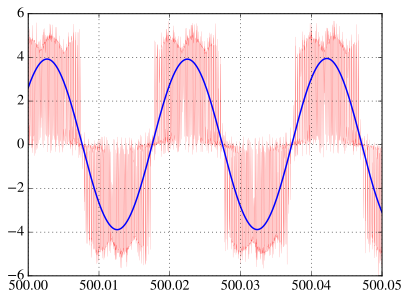

In [83]:
n1 = int( 499 * fs )
n2 = int( 501 * fs )

mpl.plot( Time[n1:n2], u1u2out[n1:n2], '-r', lw=0.1 )
mpl.plot( flt_time[n1:n2], flt_u1u2out[n1:n2], '-b', lw=1.5 )

mpl.xlim( 500.0, 500.05 )
# mpl.ylim( -6, 6 )
mpl.grid()

In [88]:
flt_time = Time.copy()
flt_i1out = i1out.copy()

for coeffs in HF_coeffs:
    print( f"filter len = {len( coeffs )}" )
    flt_time, flt_i1out = FilterSignal( coeffs, flt_time, flt_i1out )

filter len = 1063
filter len = 1015
filter len = 967
filter len = 919
filter len = 871
filter len = 811


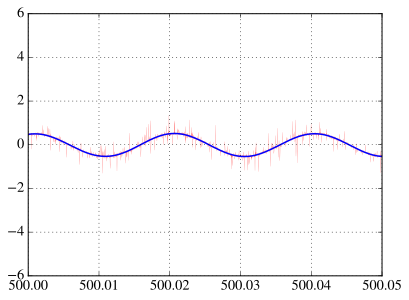

In [89]:
n1 = int( 499 * fs )
n2 = int( 501 * fs )

mpl.plot( Time[n1:n2], i1out[n1:n2], '-r', lw=0.1 )
mpl.plot( flt_time[n1:n2], flt_i1out[n1:n2], '-b', lw=1.5 )

mpl.xlim( 500.0, 500.05 )
# mpl.ylim( -6, 6 )
mpl.grid()